<a href="https://colab.research.google.com/github/jhhan0/self-study-ml/blob/main/notes/celeba-cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# load celeba dataset
celeba_builder = tfds.builder('celeb_a')
celeba_builder.download_and_prepare()
celeba = celeba_builder.as_dataset(shuffle_files=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/162770 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/celeb_a/2.0.1.incompleteAIA6DN/celeb_a-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/19867 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/celeb_a/2.0.1.incompleteAIA6DN/celeb_a-validation.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/19962 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/celeb_a/2.0.1.incompleteAIA6DN/celeb_a-test.tfrecord*...:   0%|          | 0/1…

Dataset celeb_a downloaded and prepared to ~/tensorflow_datasets/celeb_a/2.0.1. Subsequent calls will reuse this data.


In [ ]:
train_ds = celeba['train']
val_ds = celeba['validation']
test_ds = celeba['test']

In [ ]:
train_ds = train_ds.take(80000)

In [ ]:
# data augmentation
def preprocess(sample, size=(64, 64), mode='train'):
  image = sample['image']
  label = sample['attributes']['Eyeglasses']
  if mode == 'train':
    image_cropped = tf.image.random_crop(image, size=(178, 178, 3))
    image_resized = tf.image.resize(image_cropped, size=size)
    image_adj_bri = tf.image.random_brightness(image_resized, max_delta=0.3)
    image_flip = tf.image.random_flip_up_down(image_adj_bri)
    return tf.cast(image_flip, tf.float32) / 255.0, tf.cast(label, tf.uint8)
  else:
    image_cropped = tf.image.crop_to_bounding_box(image, offset_height=20, offset_width=0, target_height=178, target_width=178)
    image_resize = tf.image.resize(image_cropped, size=size)
    return tf.cast(image_resize, tf.float32) / 255.0, tf.cast(label, tf.uint8)

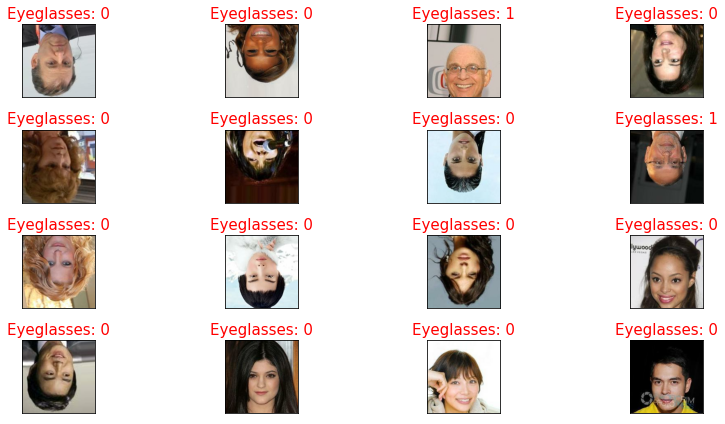

In [ ]:
tf.random.set_seed(1)
ds = train_ds.shuffle(100, reshuffle_each_iteration=False)
ds = ds.take(16)
ds = ds.map(lambda x: preprocess(x, size=(178, 178), mode='train'))
fig = plt.figure(figsize=(12, 6))
for i, sample in enumerate(ds):
  ax = fig.add_subplot(4, 4, i+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(sample[0].numpy())
  ax.set_title('Eyeglasses: {}'.format(sample[1]), size=15, color='red')
plt.tight_layout()
plt.show()

In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = (64, 64)
BUFFER_SIZE = 80000

train_ds = train_ds.map(lambda x: preprocess(x, size=IMAGE_SIZE, mode='train'))
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE).batch(BATCH_SIZE)
val_ds = val_ds.map(lambda x: preprocess(x, size=IMAGE_SIZE, mode='val')).batch(BATCH_SIZE)

In [ ]:
# create model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
])

In [ ]:
# add GlobalAveragePooling and Dense layer at the end
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1, activation=None))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

In [ ]:
# compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
# train the model
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
1250/1250 [==============================] - 69s 49ms/step - loss: 0.2403 - accuracy: 0.9347 - val_loss: 0.2502 - val_accuracy: 0.9304
Epoch 2/10
1250/1250 [==============================] - 61s 49ms/step - loss: 0.2045 - accuracy: 0.9370 - val_loss: 0.1638 - val_accuracy: 0.9390
Epoch 3/10
1250/1250 [==============================] - 61s 48ms/step - loss: 0.1280 - accuracy: 0.9553 - val_loss: 0.0897 - val_accuracy: 0.9626
Epoch 4/10
1250/1250 [==============================] - 60s 48ms/step - loss: 0.0951 - accuracy: 0.9667 - val_loss: 0.0755 - val_accuracy: 0.9651
Epoch 5/10
1250/1250 [==============================] - 61s 48ms/step - loss: 0.0797 - accuracy: 0.9717 - val_loss: 0.0675 - val_accuracy: 0.9673
Epoch 6/10
1250/1250 [==============================] - 61s 48ms/step - loss: 0.0675 - accuracy: 0.9758 - val_loss: 0.0536 - val_accuracy: 0.9779
Epoch 7/10
1250/1250 [==============================] - 63s 50ms/step - loss: 0.0616 - accuracy: 0.9782 - val_loss: 0.0431 -

In [ ]:
model.save('celeba-cnn.h5', overwrite=True, include_optimizer=True, save_format='h5')

In [ ]:
test_ds = test_ds.map(lambda x: preprocess(x, size=IMAGE_SIZE, mode='test')).batch(BATCH_SIZE)

In [ ]:
results = model.evaluate(test_ds)
print('Test loss: {:.3f}, Test acc: {:.3f}'.format(*results))

312/312 [==============================] - 9s 28ms/step - loss: 0.0366 - accuracy: 0.9888
Test loss: 0.037, Test acc: 0.989


In [ ]:
# display 25 celeba test images with actual label and predicted value
samples = test_ds.unbatch().take(10)

In [ ]:
logits = model.predict(samples.batch(1))
probas = np.round(tf.sigmoid(logits).numpy().flatten(), decimals=2)*100
print(probas)

10/10 [==============================] - 0s 7ms/step
[  0.   0.   0.  44.   0.   2.   0. 100.   0.   0.]


In [ ]:
class_labels = ['No EG', 'With EG']

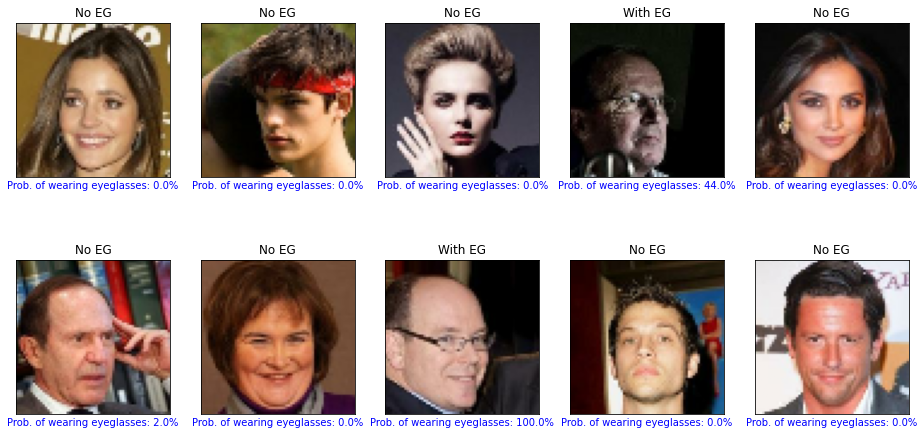

In [ ]:
fig = plt.figure(figsize=(16, 8))
for element in samples.enumerate():
  ax = fig.add_subplot(2, 5, element[0].numpy()+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('Prob. of wearing eyeglasses: {}%'.format(probas[element[0].numpy()]), color='blue')
  ax.set_title('{}'.format(class_labels[element[1][1].numpy()]))
  ax.imshow(element[1][0].numpy())
plt.show()